# Access the data from the pipeline 

In [1]:
from lsst.daf.butler import Butler
import lsst.afw.display as afwDisplay
import lsst.geom


from astropy.nddata import Cutout2D
import matplotlib.pyplot as plt
from astropy.visualization import simple_norm
from astropy.visualization import (MinMaxInterval, SqrtStretch,
                                   ImageNormalize)
import pandas as pd
pd.set_option('display.float_format', lambda x: '%d' % x)

import numpy as np
from pipeline_to_notebook import extract_all_single_visit, save_cutout, call_visit, plot_from_source 

In [2]:
repo = "/sps/lsst/groups/transients/HSC/fouchez/RC2_repo/butler.yaml"

In [3]:
import warnings; warnings.simplefilter('ignore')


In [4]:
# Generic imports
import os,glob
import pylab as plt

In [5]:
# Create a new butler with the collection of interest
collection = 'run/ssp_ud_cosmos/step5_new'
butler = Butler(repo, collections=collection)
registry = butler.registry

#filter the dataset
datasetRefs = registry.queryDatasetTypes('good*')
datasetRefs

[DatasetType('goodSeeingVisits', {band, instrument, skymap, tract, patch}, StructuredDataDict),
 DatasetType('goodSeeingCoadd', {band, skymap, tract, patch}, ExposureF),
 DatasetType('goodSeeingCoadd_nImage', {band, skymap, tract, patch}, ImageU),
 DatasetType('goodSeeingDiff_diaSrc_schema', {}, SourceCatalog),
 DatasetType('goodSeeingDiff_templateExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF),
 DatasetType('goodSeeingDiff_differenceTempExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF),
 DatasetType('goodSeeingDiff_matchedExp', {band, instrument, day_obs, detector, physical_filter, visit}, ExposureF),
 DatasetType('goodSeeingDiff_psfMatchKernel', {band, instrument, day_obs, detector, physical_filter, visit}, MatchingKernel),
 DatasetType('goodSeeingDiff_diaSrc', {band, instrument, day_obs, detector, physical_filter, visit}, SourceCatalog),
 DatasetType('goodSeeingDiff_differenceExp', {band, instrument, day_obs, detector, ph

In [6]:
datasetRefs = registry.queryDatasets(datasetType='goodSeeingDiff_assocDiaSrcTable', collections=collection)

dataIds = []
for i,ref in enumerate(datasetRefs):
    dataIds.append(ref.dataId)
print(len(dataIds))
print(dataIds[0])

detecs = butler.get('goodSeeingDiff_assocDiaSrcTable', dataId=dataIds[0])

for col in detecs.columns:
    if 'flux ' in col or 'Flux' in col:
        print(col)

79
{skymap: 'hsc_rings_v1', tract: 9813, patch: 56}
apFlux
apFluxErr
psfFlux
psfFluxErr
trailFlux
dipoleMeanFlux
dipoleMeanFluxErr
dipoleFluxDiff
dipoleFluxDiffErr
scienceFlux
scienceFluxErr
apFlux_flag
apFlux_flag_apertureTruncated
psfFlux_flag
psfFlux_flag_noGoodPixels
psfFlux_flag_edge
forced_PsfFlux_flag
forced_PsfFlux_flag_noGoodPixels
forced_PsfFlux_flag_edge


## Visit summary (Get list all visit and others)

In [7]:
# all visit UDEEP
datasetRefs = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp',collections=collection)

# Make sure we are having an array listing all the visits (must appeared once)
visits = []
for ref in datasetRefs:
    visits.append(ref.dataId['visit'])
visits = np.unique(visits)

In [8]:
visits

array([   274,    276,    282,    284,    286,    288,    290,    292,
          294,    296,    298,    300,    302,    306,    308,    310,
          312,    314,    316,    318,    320,    322,    324,    326,
          328,    330,    332,    334,    340,    342,    344,    346,
          348,    350,    352,    354,    356,    358,    360,    362,
          364,    366,    368,    370,   1164,   1166,   1168,   1170,
         1172,   1174,   1176,   1178,   1180,   1182,   1184,   1186,
         1188,   1190,   1192,   1194,   1200,   1202,   1204,   1206,
         1208,   1210,   1212,   1214,   1216,   1218,   1220,   1222,
         1226,   1228,   1230,   1232,   1234,   1236,   1238,   1240,
         1242,   1244,   1246,   1248,   1856,   1858,   1860,   1862,
         1864,   1868,   1870,   1872,   1874,   1876,   1878,   1880,
         1882,   1886,   1888,   1890,  11688,  11690,  11692,  11694,
        11696,  11698,  11700,  11702,  11704,  11706,  11708,  11710,
      

In [10]:
len(visits)

862

In [26]:
def split_list(input_list, chunk_size):
    return [input_list[i:i + chunk_size] for i in range(0, len(input_list), chunk_size)]

split_list(visits, 20)

[array([274, 276, 282, 284, 286, 288, 290, 292, 294, 296, 298, 300, 302,
        306, 308, 310, 312, 314, 316, 318]),
 array([320, 322, 324, 326, 328, 330, 332, 334, 340, 342, 344, 346, 348,
        350, 352, 354, 356, 358, 360, 362]),
 array([ 364,  366,  368,  370, 1164, 1166, 1168, 1170, 1172, 1174, 1176,
        1178, 1180, 1182, 1184, 1186, 1188, 1190, 1192, 1194]),
 array([1200, 1202, 1204, 1206, 1208, 1210, 1212, 1214, 1216, 1218, 1220,
        1222, 1226, 1228, 1230, 1232, 1234, 1236, 1238, 1240]),
 array([1242, 1244, 1246, 1248, 1856, 1858, 1860, 1862, 1864, 1868, 1870,
        1872, 1874, 1876, 1878, 1880, 1882, 1886, 1888, 1890]),
 array([11688, 11690, 11692, 11694, 11696, 11698, 11700, 11702, 11704,
        11706, 11708, 11710, 11712, 11716, 11718, 11720, 11722, 11724,
        11726, 11728]),
 array([11730, 11732, 11734, 11736, 11738, 11740, 11742, 17898, 17900,
        17902, 17904, 17906, 17908, 17926, 17928, 17930, 17932, 17934,
        17944, 17946]),
 array([17948, 179

In [12]:
datasetRefs = registry.queryDatasets('visitSummary')
for ref in datasetRefs: 
    print(ref)

visitSummary@{instrument: 'HSC', visit: 11696, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'} [sc=ExposureCatalog] (run=run/ssp_ud_cosmos/step2a/20240924T153931Z id=647e8b43-f28d-42a8-b1b7-1d6b29866aab)
visitSummary@{instrument: 'HSC', visit: 53736, band: 'z', day_obs: 20160115, physical_filter: 'HSC-Z'} [sc=ExposureCatalog] (run=run/ssp_ud_cosmos/step2a/20240924T153931Z id=5e5fccf5-39d0-4e43-bc6c-5338d91111f9)
visitSummary@{instrument: 'HSC', visit: 53748, band: 'z', day_obs: 20160115, physical_filter: 'HSC-Z'} [sc=ExposureCatalog] (run=run/ssp_ud_cosmos/step2a/20240924T153931Z id=e68ddbd2-f3ba-4372-968c-11e20c83e965)
visitSummary@{instrument: 'HSC', visit: 280, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'} [sc=ExposureCatalog] (run=run/ssp_ud_cosmos/step2a/20240924T153931Z id=7f3139cd-76b1-427c-8924-fa338cf270c1)
visitSummary@{instrument: 'HSC', visit: 113486, band: 'i', day_obs: 20170427, physical_filter: 'HSC-I2'} [sc=ExposureCatalog] (run=run/ssp_ud_cosmos/step2

In [13]:
def date_to_mjd(date_str):
    year = int(date_str[:4])
    month = int(date_str[4:6])
    day = int(date_str[6:])
    if month <= 2:
        year -= 1
        month += 12
    A = year // 100
    B = 2 - A + (A // 4)
    jd = int(365.25 * (year + 4716)) + int(30.6001 * (month + 1)) + day + B - 1524.5
    mjd = jd - 2400000.5
    
    return mjd


In [14]:
day_obs = []
visit = []
for ref in datasetRefs: 
    
    day_obs.append(date_to_mjd(str(ref.dataId['day_obs'])))
    visit.append(ref.dataId['visit'])
    # Create the DataFrame
    time_dict_gen3 = pd.DataFrame({
        'visit': visit,
        'day_obs': day_obs
    })

    # Set 'visit' as the index
    time_dict_gen3 = time_dict_gen3.set_index('visit')

In [15]:
time_dict_gen3.to_dict()

{'day_obs': {11696: 56979.0,
  53736: 57402.0,
  53748: 57402.0,
  280: 56741.0,
  113486: 57870.0,
  57922: 57430.0,
  96198: 57774.0,
  102234: 57787.0,
  103712: 57809.0,
  22658: 57049.0,
  30486: 57163.0,
  340: 56741.0,
  17904: 57038.0,
  95088: 57755.0,
  104516: 57816.0,
  93420: 57747.0,
  104170: 57811.0,
  54126: 57421.0,
  59904: 57456.0,
  108202: 57842.0,
  105752: 57833.0,
  93394: 57747.0,
  97506: 57778.0,
  95100: 57755.0,
  62994: 57462.0,
  104512: 57816.0,
  28390: 57155.0,
  102114: 57787.0,
  1208: 56744.0,
  93832: 57748.0,
  11718: 56979.0,
  92542: 57745.0,
  104514: 57816.0,
  300: 56741.0,
  100750: 57783.0,
  92594: 57745.0,
  23694: 57099.0,
  102222: 57787.0,
  105776: 57833.0,
  114508: 57872.0,
  56840: 57427.0,
  103738: 57809.0,
  56814: 57427.0,
  93774: 57748.0,
  116412: 57924.0,
  19682: 57043.0,
  103118: 57807.0,
  95830: 57757.0,
  296: 56741.0,
  106160: 57834.0,
  97540: 57778.0,
  108204: 57842.0,
  103816: 57809.0,
  17902: 57038.0,
  2260

In [73]:
time_dict_gen3 = {19696: 57043.0,
  11694: 56979.0,
  19694: 57043.0,
  358: 56741.0,
  17904: 57038.0,
  23694: 57099.0,
  1242: 56744.0,
  1178: 56744.0,
  19680: 57043.0,
  23706: 57099.0,
  19684: 57043.0,
  17948: 57038.0,
  11710: 56979.0,
  22632: 57049.0,
  17906: 57038.0,
  1206: 56744.0,
  346: 56741.0,
  17900: 57038.0,
  29350: 57159.0,
  1214: 56744.0,
  22662: 57049.0,
  11740: 56979.0,
  11724: 56979.0,
  11704: 56979.0,
  17950: 57038.0,
  17926: 57038.0,
  23704: 57099.0,
  11696: 56979.0,
  1184: 56744.0,
  1248: 56744.0,
  11738: 56979.0,
  11690: 56979.0,
  1220: 56744.0,
  30490: 57163.0,
  11698: 56979.0,
  322: 56741.0,
  1204: 56744.0,
  23718: 57099.0,
  30482: 57163.0,
  29336: 57159.0}

## Associations tables

In [16]:
datasetRefs = registry.queryDatasets('goodSeeingDiff_assocDiaSrcTable')
full_dia_source_table =[]
for ref in datasetRefs: 
    dia_source_table =  butler.get('goodSeeingDiff_assocDiaSrcTable', dataId = ref.dataId)
    full_dia_source_table.append(dia_source_table)
    
full_dia_source_table = pd.concat(full_dia_source_table)

In [17]:
full_dia_source_table['is_injection']=0
full_dia_source_table

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,is_injection
diaSourceId,,,,,,,,,,,,,,,,,,,,,
12595554236235905,29326,62,g,3496046754095171303,0,0,57159,36,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235908,29326,62,g,3496046754095186145,0,0,57159,16,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235910,29326,62,g,3496046754095186146,0,0,57159,34,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235914,29326,62,g,3496046754095186147,0,0,57159,14,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235916,29326,62,g,3496046754095186148,0,0,57159,81,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47827160227905681,111356,57,r,3495936802932396908,0,0,57866,57,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0
47827160227905683,111356,57,r,3495936802932430253,0,0,57866,29,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0
47827160227905684,111356,57,r,3495936802932393876,0,0,57866,28,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0


In [18]:
datasetRefs = registry.queryDatasets('goodSeeingDiff_diaObjTable')
full_dia_obj_table = []
for ref in datasetRefs: 
    dia_obj_table = butler.get('goodSeeingDiff_diaObjTable', dataId = ref.dataId)
    full_dia_obj_table.append(dia_obj_table)
full_dia_obj_table = pd.concat(full_dia_obj_table)

In [19]:
full_dia_obj_table

,ra,dec,nDiaSources
diaObjectId,,,
3496020365816102913,150,2,17
3496020365816102914,150,2,76
3496020365816102915,150,2,21
3496020365816102916,150,2,34
3496020365816102917,150,2,10
...,...,...,...
3496064346281251750,149,2,1
3496064346281251751,149,2,1
3496064346281251752,149,2,1


In [20]:
import pickle
with open("saved/full_dia_obj_table.pkl", "wb") as pickle_file:
    pickle.dump(full_dia_obj_table, pickle_file)

In [10]:
repo_injected = "/sps/lsst/users/bsanchez/hsc_processing/pgrc2subset_2/butler.yaml"
collection_injected = 'u/rbonnetguerrini/injected_step7'
butler_injected = Butler(repo_injected,collections=collection_injected)
registry_injected = butler_injected.registry

full_dia_source_table_injected =[]
datasetRefs_injected = registry_injected.queryDatasets(datasetType='injected_goodSeeingDiff_differenceExp', collections=collection_injected)

for ref in datasetRefs_injected:

    dia_source_table_injected = butler_injected.get('injected_goodSeeingDiff_diaSrcTable', dataId = ref.dataId)  # coordinates of the different object in the diff
    match_dia_source_table = butler_injected.get('injected_goodSeeingDiff_matchDiaSrc', dataId = ref.dataId) #table including the matching
    #Create the label
    dia_source_table_injected['is_injection'] = dia_source_table_injected.diaSourceId.isin(match_dia_source_table.diaSourceId).astype(int)
    
    full_dia_source_table_injected.append(dia_source_table_injected)
    
full_dia_source_table_injected = pd.concat(full_dia_source_table_injected)

In [11]:
full_dia_source_table_injected

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_not_contained,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection
0,5020904815853569,11690,41,g,0,0,0,56979.541587,19,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
1,5020904815853570,11690,41,g,0,0,0,56979.541587,32,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
2,5020904815853571,11690,41,g,0,0,0,56979.541587,27,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
3,5020904815853572,11690,41,g,0,0,0,56979.541587,16,2024-08-21 11:31:54.650612,...,False,False,False,False,False,True,True,False,False,1
4,5020904815853573,11690,41,g,0,0,0,56979.541587,29,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9733379440246987,22662,58,y,0,0,0,57049.648545,23,2024-08-21 11:24:18.793658,...,False,False,False,False,False,True,True,False,False,1
182,9733379440246988,22662,58,y,0,0,0,57049.648545,27,2024-08-21 11:24:18.793658,...,False,False,False,False,False,False,False,False,False,0
183,9733379440246989,22662,58,y,0,0,0,57049.648545,20,2024-08-21 11:24:18.793658,...,False,False,False,False,False,False,False,False,False,0
184,9733379440246990,22662,58,y,0,0,0,57049.648545,19,2024-08-21 11:24:18.793658,...,False,False,False,False,False,False,False,False,False,0


In [12]:
len(full_dia_source_table_injected[full_dia_source_table_injected['is_injection']==1])

13118

In [13]:
import pickle
with open("saved/full_dia_source_table_injected.pkl", "wb") as pickle_file:
    pickle.dump(full_dia_source_table_injected, pickle_file)

In [14]:
full_dia_source_table_injected

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_not_contained,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection
0,5020904815853569,11690,41,g,0,0,0,56979.541587,19,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
1,5020904815853570,11690,41,g,0,0,0,56979.541587,32,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
2,5020904815853571,11690,41,g,0,0,0,56979.541587,27,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
3,5020904815853572,11690,41,g,0,0,0,56979.541587,16,2024-08-21 11:31:54.650612,...,False,False,False,False,False,True,True,False,False,1
4,5020904815853573,11690,41,g,0,0,0,56979.541587,29,2024-08-21 11:31:54.650612,...,False,False,False,False,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,9733379440246987,22662,58,y,0,0,0,57049.648545,23,2024-08-21 11:24:18.793658,...,False,False,False,False,False,True,True,False,False,1
182,9733379440246988,22662,58,y,0,0,0,57049.648545,27,2024-08-21 11:24:18.793658,...,False,False,False,False,False,False,False,False,False,0
183,9733379440246989,22662,58,y,0,0,0,57049.648545,20,2024-08-21 11:24:18.793658,...,False,False,False,False,False,False,False,False,False,0
184,9733379440246990,22662,58,y,0,0,0,57049.648545,19,2024-08-21 11:24:18.793658,...,False,False,False,False,False,False,False,False,False,0


In [21]:
with open("saved/full_dia_source_table_UDEEP.pkl", "wb") as pickle_file:
    pickle.dump(full_dia_source_table, pickle_file)

In [22]:
full_dia_source_table

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,is_injection
diaSourceId,,,,,,,,,,,,,,,,,,,,,
12595554236235905,29326,62,g,3496046754095171303,0,0,57159,36,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235908,29326,62,g,3496046754095186145,0,0,57159,16,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235910,29326,62,g,3496046754095186146,0,0,57159,34,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235914,29326,62,g,3496046754095186147,0,0,57159,14,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
12595554236235916,29326,62,g,3496046754095186148,0,0,57159,81,2024-10-30 04:08:27.713729,150,...,False,False,False,False,False,False,False,150,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47827160227905681,111356,57,r,3495936802932396908,0,0,57866,57,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0
47827160227905683,111356,57,r,3495936802932430253,0,0,57866,29,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0
47827160227905684,111356,57,r,3495936802932393876,0,0,57866,28,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0


## SNR fakes


Manual computation of the SNR for the non detectedinjected sources, from Bruno, should be part of the pipeline for future versions


In [11]:
from lsst.afw import table as afwTable
from lsst import geom as lsstGeom
import lsst.pex.config as pexConfig
from lsst.pipe.base import PipelineTask, PipelineTaskConnections, Struct
import lsst.pipe.base.connectionTypes as connTypes
from lsst.meas.base import ForcedMeasurementTask, ForcedMeasurementConfig
from lsst.source.injection import VisitInjectConfig

from astropy.table import Table

In [12]:
def _estimateFakesSNR(injectedCat, diffIm):
    """Estimate the signal-to-noise ratio of the fakes in the given catalog.

    Parameters
    ----------
    injectedCat : `astropy.table.Table`
        Catalog of synthetic sources to estimate the S/N of. **This table
        will be modified in place**.
    diffIm : `lsst.afw.image.Exposure`
        Difference image where the sources were detected.
    """
    # Create a schema for the forced measurement task
    schema = afwTable.SourceTable.makeMinimalSchema()
    schema.addField("x", "D", "x position in image.", units="pixel")
    schema.addField("y", "D", "y position in image.", units="pixel")
    schema.addField("deblend_nChild", "I", "Need for minimal forced phot schema")

    pluginList = [
        "base_PixelFlags",
        "base_SdssCentroid",
        "base_CircularApertureFlux",
        "base_PsfFlux",
        "base_LocalBackground"
    ]
    forcedMeasConfig = ForcedMeasurementConfig(plugins=pluginList)
    forcedMeasConfig.slots.centroid = 'base_SdssCentroid'
    forcedMeasConfig.slots.shape = None

    # Create the forced measurement task
    forcedMeas = ForcedMeasurementTask(schema, config=forcedMeasConfig)

    # Specify the columns to copy from the input catalog to the output catalog
    forcedMeas.copyColumns = {"coord_ra": "ra", "coord_dec": "dec"}

    # Create an afw table from the input catalog
    outputCatalog = afwTable.SourceCatalog(schema)
    outputCatalog.reserve(len(injectedCat))
    for row in injectedCat:
        outputRecord = outputCatalog.addNew()
        outputRecord.setId(row['injection_id'])
        outputRecord.setCoord(lsstGeom.SpherePoint(row["ra_ssi"], row["dec_ssi"], lsstGeom.degrees))
        outputRecord.set("x", row["x_ssi"])
        outputRecord.set("y", row["y_ssi"])

    # Generate the forced measurement catalog
    forcedSources = forcedMeas.generateMeasCat(diffIm, outputCatalog, diffIm.getWcs())
    # Attach the PSF shape footprints to the forced measurement catalog
    forcedMeas.attachPsfShapeFootprints(forcedSources, diffIm)

    # Copy the x and y positions from the forced measurement catalog back
    # to the input catalog
    for src, tgt in zip(forcedSources, outputCatalog):
        src.set('base_SdssCentroid_x', tgt['x'])
        src.set('base_SdssCentroid_y', tgt['y'])

    # Define the centroid for the forced measurement catalog
    forcedSources.defineCentroid('base_SdssCentroid')
    # Run the forced measurement task
    forcedMeas.run(forcedSources, diffIm, outputCatalog, diffIm.getWcs())
    # Convert the forced measurement catalog to an astropy table
    forcedSources_table = forcedSources.asAstropy()

    # Add the forced measurement columns to the input catalog
    for column in forcedSources_table.columns:
        if "Flux" in column:
            injectedCat["forced_"+column] = forcedSources_table[column]

    # Add the SNR columns to the input catalog
    for column in injectedCat.colnames:
        if column.endswith("instFlux"):
            flux = injectedCat[column]
            fluxErr = injectedCat[column+"Err"].copy()
            fluxErr = np.where(
                (fluxErr <= 0) | (np.isnan(fluxErr)), np.nanmax(fluxErr), fluxErr)

            injectedCat[column+"_SNR"] = flux / fluxErr

In [13]:
full_match_source_table =[]

for ref in datasetRefs: 
    match_source_table = butler_injected.get('injected_goodSeeingDiff_matchDiaSrc', dataId = ref.dataId)
    diff_array = butler.get('injected_goodSeeingDiff_differenceExp', dataId =  ref.dataId)
    match_source_table_as=Table.from_pandas(match_source_table)
    _estimateFakesSNR(match_source_table_as, diff_array)
    full_match_source_table.append(match_source_table_as.to_pandas())
full_match_source_table= pd.concat(full_match_source_table)

Exception in base_PsfFlux.measure on record 59: 
  File "src/PsfFlux.cc", line 120, in virtual void lsst::meas::base::PsfFluxAlgorithm::measure(lsst::afw::table::SourceRecord&, const lsst::afw::image::Exposure<float>&) const
    Invalid pixel value detected in image. {0}
lsst::meas::base::PixelValueError: 'Invalid pixel value detected in image.'

Exception in base_PsfFlux.measure on record 59: 
  File "src/PsfFlux.cc", line 120, in virtual void lsst::meas::base::PsfFluxAlgorithm::measure(lsst::afw::table::SourceRecord&, const lsst::afw::image::Exposure<float>&) const
    Invalid pixel value detected in image. {0}
lsst::meas::base::PixelValueError: 'Invalid pixel value detected in image.'

Exception in base_PsfFlux.measure on record 77: 
  File "src/PsfFlux.cc", line 120, in virtual void lsst::meas::base::PsfFluxAlgorithm::measure(lsst::afw::table::SourceRecord&, const lsst::afw::image::Exposure<float>&) const
    Invalid pixel value detected in image. {0}
lsst::meas::base::PixelValueEr

In [14]:
full_match_source_table

,injection_id,injection_flag,injection_draw_size,col0,ra_ssi,dec_ssi,source_type,mag,host_magnitude,visit_ssi,...,forced_base_CircularApertureFlux_6_0_instFlux_SNR,forced_base_CircularApertureFlux_9_0_instFlux_SNR,forced_base_CircularApertureFlux_12_0_instFlux_SNR,forced_base_CircularApertureFlux_17_0_instFlux_SNR,forced_base_CircularApertureFlux_25_0_instFlux_SNR,forced_base_CircularApertureFlux_35_0_instFlux_SNR,forced_base_CircularApertureFlux_50_0_instFlux_SNR,forced_base_CircularApertureFlux_70_0_instFlux_SNR,forced_base_LocalBackground_instFlux_SNR,forced_base_PsfFlux_instFlux_SNR
0,0,0,26,3274,150.186736,2.088932,DeltaFunction,24.299121,23.504863,11690,...,17.038669,13.451245,10.558184,7.434285,4.012053,3.600664,3.524561,2.518696,-0.022440,22.356301
1,1,0,26,3275,150.193674,2.085277,DeltaFunction,24.699272,25.346123,11690,...,12.345365,8.814169,6.912589,4.407123,1.669079,0.017260,-0.855762,-0.961306,-0.042619,17.849337
2,2,0,24,3276,150.301853,2.142673,DeltaFunction,26.014168,25.263670,11690,...,4.693545,3.621552,3.508219,2.941465,1.832827,1.189493,1.622703,3.138777,-0.020026,6.613156
3,3,0,24,3277,150.129979,2.074612,DeltaFunction,24.436909,24.922794,11690,...,13.668532,9.191428,6.042760,2.837267,0.437844,-2.881734,-6.779677,-10.486811,-0.120132,21.335574
4,4,0,26,3278,150.267056,2.113641,DeltaFunction,27.767989,25.169787,11690,...,1.440279,1.108037,0.160756,0.645748,1.315488,0.768527,1.325662,0.441008,0.032517,1.022543
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,38,0,26,707,149.959829,2.263693,DeltaFunction,22.599593,22.509599,22662,...,10.834832,8.422908,6.480215,5.847970,3.960879,4.082967,4.544950,4.408424,0.013851,16.496907
46,40,0,26,709,149.967479,2.267392,DeltaFunction,22.888391,22.820511,22662,...,7.992490,6.365432,3.888903,3.056273,1.873522,1.300867,-8.112605,-71.063369,0.008062,12.849577
47,41,0,26,710,150.042803,2.229460,DeltaFunction,22.612077,21.464116,22662,...,9.593804,7.044619,5.049071,4.509600,3.312355,3.089698,3.443093,1.923458,0.039191,16.562781
48,44,0,26,713,149.937608,2.239368,DeltaFunction,22.850345,21.507254,22662,...,7.692366,5.240378,4.658823,2.503911,1.375766,-0.355907,-1.369182,-3.378645,-0.045028,13.284115


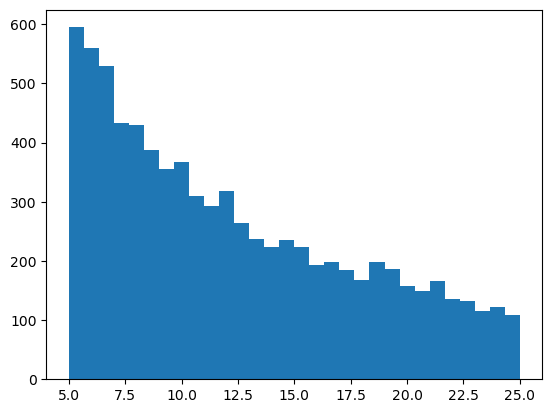

In [15]:
plt.hist(full_match_source_table['forced_base_PsfFlux_instFlux_SNR'], range=[5,25], bins=30)
plt.show()

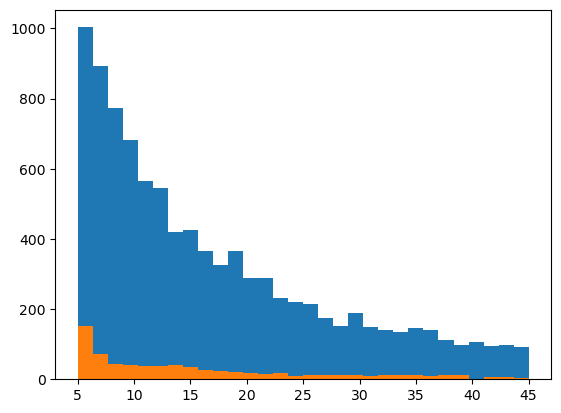

In [16]:
not_detected = full_match_source_table[full_match_source_table['diaSourceId']==0]
is_detected = full_match_source_table[full_match_source_table['diaSourceId']!=0]


plt.hist(is_detected['forced_base_PsfFlux_instFlux_SNR'], range=[5,45], bins=30)
plt.hist(not_detected['forced_base_PsfFlux_instFlux_SNR'], range=[5,45], bins=30)

plt.show()

In [33]:
low_mag_detected=is_detected[is_detected['mag']<20]
low_mag_not_detected=not_detected[not_detected['mag']<20]

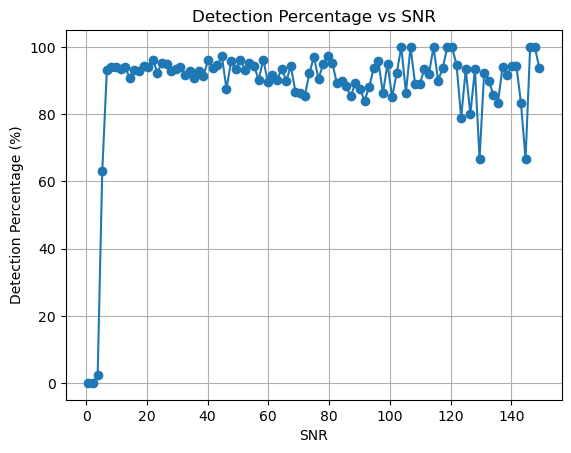

In [125]:

# Define the magnitude range and binning
bins = np.linspace(0, 150, 100)

# Get histograms for both detected and not detected
detected_hist, _ = np.histogram(is_detected['forced_base_PsfFlux_instFlux_SNR'], bins=bins)
not_detected_hist, _ = np.histogram(not_detected['forced_base_PsfFlux_instFlux_SNR'], bins=bins)

# Total sources in each bin
total_sources_hist = detected_hist + not_detected_hist

# Avoid division by zero for bins with no sources
with np.errstate(divide='ignore', invalid='ignore'):
    detection_percentage = (detected_hist / total_sources_hist) * 100

# Plot the detection percentage
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, detection_percentage, label="Detection Percentage", marker='o')
plt.xlabel('SNR')
plt.ylabel('Detection Percentage (%)')
plt.title('Detection Percentage vs SNR')
plt.grid(True)
plt.show()

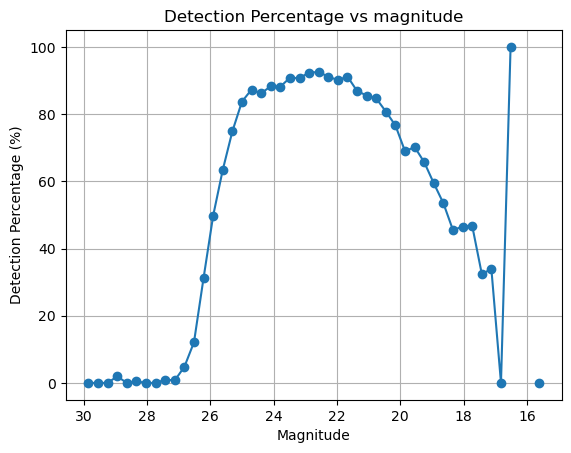

In [139]:
# Define the magnitude range and binning
bins = np.linspace(0, 30, 100)

# Get histograms for both detected and not detected
detected_hist, _ = np.histogram(is_detected['mag'], bins=bins)
not_detected_hist, _ = np.histogram(not_detected['mag'], bins=bins)

# Total sources in each bin
total_sources_hist = detected_hist + not_detected_hist

# Avoid division by zero for bins with no sources
with np.errstate(divide='ignore', invalid='ignore'):
    detection_percentage = (detected_hist / total_sources_hist) * 100

# Plot the detection percentage
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, detection_percentage, label="Detection Percentage", marker='o')
plt.xlabel('Magnitude')
plt.ylabel('Detection Percentage (%)')
plt.title('Detection Percentage vs magnitude')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

In [ ]:
is_hostless = full_match_source_table[full_match_source_table['diaSourceId']==0]
not_detected = full_match_source_table[full_match_source_table['diaSourceId']==0]


In [ ]:
# Define the magnitude range and binning
bins = np.linspace(0, 30, 100)

# Get histograms for both detected and not detected
detected_hist, _ = np.histogram(is_detected['mag'], bins=bins)
not_detected_hist, _ = np.histogram(not_detected['mag'], bins=bins)

# Total sources in each bin
total_sources_hist = detected_hist + not_detected_hist

# Avoid division by zero for bins with no sources
with np.errstate(divide='ignore', invalid='ignore'):
    detection_percentage = (detected_hist / total_sources_hist) * 100

# Plot the detection percentage
bin_centers = 0.5 * (bins[:-1] + bins[1:])
plt.plot(bin_centers, detection_percentage, label="Detection Percentage", marker='o')
plt.xlabel('SNR')
plt.ylabel('Detection Percentage (%)')
plt.title('Detection Percentage vs magnitude')
plt.gca().invert_xaxis()
plt.grid(True)
plt.show()

In [136]:
is_detected[(is_detected['visit_ssi']==19680)&(is_detected['band_ssi']=='i')&(is_detected['detector_ssi']==41)&(is_detected['mag']>26)]

,injection_id,injection_flag,injection_draw_size,col0,ra_ssi,dec_ssi,source_type,mag,host_magnitude,visit_ssi,...,forced_base_CircularApertureFlux_6_0_instFlux_SNR,forced_base_CircularApertureFlux_9_0_instFlux_SNR,forced_base_CircularApertureFlux_12_0_instFlux_SNR,forced_base_CircularApertureFlux_17_0_instFlux_SNR,forced_base_CircularApertureFlux_25_0_instFlux_SNR,forced_base_CircularApertureFlux_35_0_instFlux_SNR,forced_base_CircularApertureFlux_50_0_instFlux_SNR,forced_base_CircularApertureFlux_70_0_instFlux_SNR,forced_base_LocalBackground_instFlux_SNR,forced_base_PsfFlux_instFlux_SNR
12,14,0,22,715,150.235503,2.140136,DeltaFunction,26.023485,24.290613,19680,...,4.131549,3.347545,2.8062,3.00202,2.853185,2.889227,2.221179,3.599337,0.063901,7.231581


In [138]:
not_detected[(not_detected['band_ssi']=='i')&(not_detected['detector_ssi']==41)&(not_detected['mag']<21)]


,injection_id,injection_flag,injection_draw_size,col0,ra_ssi,dec_ssi,source_type,mag,host_magnitude,visit_ssi,...,forced_base_CircularApertureFlux_6_0_instFlux_SNR,forced_base_CircularApertureFlux_9_0_instFlux_SNR,forced_base_CircularApertureFlux_12_0_instFlux_SNR,forced_base_CircularApertureFlux_17_0_instFlux_SNR,forced_base_CircularApertureFlux_25_0_instFlux_SNR,forced_base_CircularApertureFlux_35_0_instFlux_SNR,forced_base_CircularApertureFlux_50_0_instFlux_SNR,forced_base_CircularApertureFlux_70_0_instFlux_SNR,forced_base_LocalBackground_instFlux_SNR,forced_base_PsfFlux_instFlux_SNR
31,32,0,26,222,150.392186,2.158373,DeltaFunction,18.598968,18.711477,1242,...,1272.374427,935.612746,734.742975,549.987805,389.527380,283.100642,200.269636,143.298754,0.022647,1839.957190
23,26,0,24,4088,150.166352,2.155690,DeltaFunction,19.483921,18.230340,1248,...,582.371964,414.538242,319.199406,230.540205,161.952887,118.426139,84.524645,60.387157,-0.085886,858.985897
47,60,0,24,4122,150.136804,2.114502,DeltaFunction,20.299642,20.065358,1248,...,182.113244,101.642924,85.112625,89.660025,71.054106,52.579253,37.492789,26.771703,-0.064167,338.291134
5,7,0,26,708,150.115593,2.193071,DeltaFunction,17.696142,NaN,19680,...,4190.015379,2883.509085,2180.632161,1533.155994,1036.094092,731.041462,446.195508,NaN,-0.065565,7326.204596
77,91,0,20,792,150.136316,2.114567,DeltaFunction,20.183763,20.687818,19680,...,362.696592,225.393060,143.149027,-33.502004,-82.611723,-74.344538,-57.479077,-41.583018,0.006786,749.427483
111,131,0,24,832,150.221240,2.181780,DeltaFunction,18.230061,NaN,19680,...,2344.720251,1617.355990,1221.396882,867.309120,592.959615,425.987900,300.194900,214.749902,0.028109,4808.254825
112,132,0,20,833,150.198928,2.148848,DeltaFunction,18.132349,NaN,19680,...,2595.477409,1776.812281,1326.805768,937.578082,636.886889,456.142339,323.579343,236.876564,0.025317,5379.092391
125,95,0,24,796,150.087112,2.139979,DeltaFunction,19.265144,19.847624,19680,...,231.316760,179.116063,142.866756,105.175430,72.398300,53.202901,37.246629,24.557054,-0.137059,1305.020203
82,84,0,22,4225,150.338730,2.079838,DeltaFunction,19.317217,20.160252,19684,...,621.927130,411.121723,324.380891,236.456935,164.446593,117.322143,82.551274,58.889368,-0.290201,1317.628548
107,112,0,26,4253,150.208094,2.083309,DeltaFunction,19.992535,19.694442,19684,...,93.641557,75.560620,58.736335,42.801704,30.122508,22.732495,16.781058,12.282802,-0.018532,635.720122


# Performing CutOuts

In [4]:
collection = 'u/rbonnetguerrini/injected_step6'

cutout, csv = save_cutout(collection, coadd_science = False, return_file = True, save_file = True, rotate_data = True)


322
346
358
1178
1184
1204
1206
1214
1220
1242
1248
11690
11694
11696
11698
11704
11710
11724
11738
11740
17900
17904
17906
17926
17948
17950
19680
19684
19694
19696
22632
22662
23694
23704
23706
23718
29336
29350
30482
30490
visit analysed : 40, 
exposure explored : 231, 
cutout realised : 231620


In [32]:
plot_from_source(1248, 100)

Exception ignored in: <function _collection_gced at 0x7f51543edf80>
Traceback (most recent call last):
  File "/cvmfs/sw.lsst.eu/linux-x86_64/lsst_distrib/w_2024_35/conda/envs/lsst-scipipe-9.0.0-exact-ext/lib/python3.11/site-packages/sqlalchemy/event/registry.py", line 103, in _collection_gced
    def _collection_gced(ref: weakref.ref[Any]) -> None:
    
KeyboardInterrupt: 


visit nbr : 1248, detector : 41



KeyboardInterrupt



# Detailed construction of the pipeline_to_notebook functions

In [6]:
# Create a new butler with the collection of interest
collection = 'u/rbonnetguerrini/step8'
collection = 'u/rbonnetguerrini/injected_step7'

butler = Butler(repo,collections=collection)
registry = butler.registry

#filter the dataset
datasetRefs = registry.queryDatasets(datasetType='injected_goodSeeingDiff_differenceExp',collections=collection)


In [7]:
#extract all of the dataID of the interesting exposure
dataIds = []  #contains all the data ids

for ref in datasetRefs:
    dataIds.append(ref.dataId)
    print(ref.dataId)
print(len(dataIds))

{instrument: 'HSC', detector: 41, visit: 11690, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 11694, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 11696, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 11698, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 11704, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 11710, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 29336, band: 'g', day_obs: 20150517, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 41, visit: 29350, band: 'g', day_obs: 20150517, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 42, visit: 11690, band: 'g', day_obs: 20141118, physical_filter: 'HSC-G'}
{instrument: 'HSC', detector: 42, visit: 11694, band: 'g', day_o

In [8]:
# function to extract the dataId of a single visit for all detectors (ccds) 

def extract_all_single_visit(visit_id, collection):
    dataIds = []
    result = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp', 
                                    collections=collection, 
                                    where= f"visit = {visit_id}")
    
    
    result = registry.queryDatasets(datasetType='injected_goodSeeingDiff_differenceExp', 
                                    collections=collection, 
                                    where= f"visit = {visit_id}")
    
    
    for ref in result:
        dataIds.append(ref.dataId)
        
    return dataIds

In [9]:
print(extract_all_single_visit(322,collection))


"""for ref in extract_all_single_visit(322): 
    print(ref.dataId.full)
"""


[{instrument: 'HSC', detector: 41, visit: 322, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'}, {instrument: 'HSC', detector: 42, visit: 322, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'}, {instrument: 'HSC', detector: 47, visit: 322, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'}, {instrument: 'HSC', detector: 49, visit: 322, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'}, {instrument: 'HSC', detector: 50, visit: 322, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'}, {instrument: 'HSC', detector: 58, visit: 322, band: 'y', day_obs: 20140325, physical_filter: 'HSC-Y'}]


'for ref in extract_all_single_visit(322): \n    print(ref.dataId.full)\n'

In [10]:
# sort those by visit
visits = []

for ref in datasetRefs:
    visits.append(ref.dataId['visit'])
visits = np.unique(visits)
print(len(visits))





40


In [11]:
full_dia_source_table = butler.get('injected_goodSeeingDiff_diaSrcTable', dataId = dataIds[0])
match_dia_source_table = butler.get('injected_goodSeeingDiff_matchDiaSrc', dataId = dataIds[0])

In [12]:
full_dia_source_table = butler.get('injected_goodSeeingDiff_diaSrc', dataId = dataIds[0])


In [13]:
full_dia_source_table.schema

Schema(
    (Field['L'](name="id", doc="unique ID"), Key<L>(offset=0, nElements=1)),
    (Field['Angle'](name="coord_ra", doc="position in ra/dec"), Key<Angle>(offset=8, nElements=1)),
    (Field['Angle'](name="coord_dec", doc="position in ra/dec"), Key<Angle>(offset=16, nElements=1)),
    (Field['L'](name="parent", doc="unique ID of parent source"), Key<L>(offset=24, nElements=1)),
    (Field['F'](name="coord_raErr", doc="1-sigma uncertainty on ra", units="rad"), Key<F>(offset=32, nElements=1)),
    (Field['F'](name="coord_decErr", doc="1-sigma uncertainty on dec", units="rad"), Key<F>(offset=36, nElements=1)),
    (Field['F'](name="coord_ra_dec_Cov", doc="uncertainty covariance between ra and dec", units="rad rad"), Key<F>(offset=40, nElements=1)),
    (Field['Flag'](name="flags_negative", doc="set if source was detected as significantly negative"), Key['Flag'](offset=48, bit=0)),
    (Field['I'](name="deblend_nChild", doc="Number of children this object has (defaults to 0)"), Key<I>

In [14]:
match_dia_source_table['time_processed']

0    2024-08-21 11:31:54.650612
1    2024-08-21 11:31:54.650612
2    2024-08-21 11:31:54.650612
3    2024-08-21 11:31:54.650612
4                           NaT
                ...            
78   2024-08-21 11:31:54.650612
79   2024-08-21 11:31:54.650612
80   2024-08-21 11:31:54.650612
81                          NaT
82   2024-08-21 11:31:54.650612
Name: time_processed, Length: 83, dtype: datetime64[us]

In [15]:

full_dia_source_table['is_injection'] = full_dia_source_table.diaSourceId.isin(match_dia_source_table.diaSourceId)
print(len(full_dia_source_table[(full_dia_source_table['is_injection']==False)&(full_dia_source_table['pixelFlags_injectedCenter']==True)]))

AttributeError: 'lsst.afw.table._table.SourceColumnView' object has no attribute 'diaSourceId'

In [6]:
from scipy.ndimage import rotate

def save_cutout(collection, coadd_science= False, return_file = False, save_file = False, rotate_data = False): 
    '''
    From a given collection, perform cutout and save them visit by visit.
    
    Parameters:
        collection (str) : path to collection
    
    Returns: 
    
    '''
    all_cutout_in_collection = []
    all_features_in_collection = []
    
    butler = Butler(repo,collections=collection)
    registry = butler.registry

    #filter the dataset
    datasetRefs = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp',collections=collection)
    datasetRefs = registry.queryDatasets(datasetType='injected_goodSeeingDiff_differenceExp',collections=collection)

    # Make sure we are having an array listing all the visits (must appeared once)
    visits = []
    for ref in datasetRefs:
        visits.append(ref.dataId['visit'])
    visits = np.unique(visits)
    visits = [322]
    nbr_cutout =0
    nbr_visit = 0
    nbr_exposure = 0
    rotation_angles = [90, 180, 270]

    # Going through the list of unique visit and then call all the ccd/detector, so we can save all object of the same visit together
    for visit in visits: 
        print(visit)
        nbr_visit = nbr_visit+1
        # Extract the IDs for a given visit (each ID correspond to one ccd/detector)
        all_cutout_in_visit = []
        all_features_in_visit = []
        new_rows = []  
        rotated_cutouts = []
        for ref in extract_all_single_visit(visit, collection): 
            nbr_exposure =  nbr_exposure + 1

            # Extract all the objects of the given ccd/detector
            diff_array = butler.get('injected_goodSeeingDiff_differenceExp', dataId = ref).getImage().array # extract the image from the butler exposure 
            if coadd_science : 
                coadd_array = butler.get('injected_goodSeeingDiff_templateExp', dataId = ref).getImage().array # extract the image from the butler COADD 
                science_array = butler.get('injected_calexp', dataId = ref).getImage().array # extract the image from the butler CALEXP 

            full_dia_source_table = butler.get('injected_goodSeeingDiff_diaSrcTable', dataId = ref)  # coordinates of the different object in the diff
            match_dia_source_table = butler.get('injected_goodSeeingDiff_matchDiaSrc', dataId = ref) #table including the matching

            #Create the label
            full_dia_source_table['is_injection'] = full_dia_source_table.diaSourceId.isin(match_dia_source_table.diaSourceId)
            coord = full_dia_source_table

            num_detections=len(coord['x'])
            coord['rotation_angle'] = None

            for detect in range(num_detections):
                cutout = Cutout2D(diff_array, (coord['x'][detect], coord['y'][detect]), 30)  # Proceed to the cutouts using the astropy tool 
                if coadd_science: 
                    cutout_coadd = Cutout2D(coadd_array, (coord['x'][detect], coord['y'][detect]), 30)  # Proceed to the cutouts using the astropy tool 
                    cutout_science = Cutout2D(science_array, (coord['x'][detect], coord['y'][detect]), 30)  # Proceed to the cutouts using the astropy tool 

                # Check the cutout data format
                if cutout.data.shape == (30, 30) and not np.isnan(cutout.data).any():
                    # Store the original cutout (no rotation, angle = 0°)
                    if rotate_data:
                        original_cutout = cutout.data

                        # Create a new row in the catalog for the original cutout
                        new_row = coord.iloc[[detect]].copy() 
                        # Apply rotations and store the rotated versions
                        for angle in rotation_angles:  
                            rotated_cutout = rotate(cutout.data, angle, reshape=False)  # Reshape=False to keep the same dimensions

                            # Create a new row by copying the existing one and modifying the rotation angle
                            rotated_row = new_row.copy()  # Copy the original row
                            rotated_row['rotation_angle'] = angle  # Update the rotation angle
                            new_rows.append(rotated_row)  # Append the rotated row to new rows
                            rotated_cutouts.append(rotated_cutout)
                            nbr_cutout = nbr_cutout+1
                        
                            
                    all_cutout_in_visit.append(cutout.data)                 
                    all_features_in_visit.append(coord.iloc[detect])
                    nbr_cutout = nbr_cutout+1

                    if coadd_science:
                        all_cutout_coadd_in_visit.append(cutout_coadd.data)
                        all_cutout_science_in_visit.append(cutout_science.data) 

        
        
        print(np.array(all_cutout_in_visit).shape)
        print(np.array(all_features_in_visit).shape)
        all_features_in_visit = pd.DataFrame(all_features_in_visit)
        new_rows_df = pd.concat(new_rows, ignore_index=True)  # Concatenate rotated rows into a single DataFrame
        all_cutout_in_visit = np.concatenate((all_cutout_in_visit, rotated_cutouts))
        all_features_in_visit = pd.concat([all_features_in_visit, new_rows_df], ignore_index=True)


        if save_file == True:
            if rotate_data :
                np.save(f'saved/cutouts/Detected_obj_sources_rotated_visit_{visit}.npy', all_cutout_in_visit)
                all_features_in_visit.to_csv(f'saved/csv/Detected_obj_sources_rotated_visit_{visit}.csv')
                if coadd_science :
                    np.save(f'saved/cutouts_coadd/Coadd_detected_obj_sources_visit_{visit}.npy', all_cutout_coadd_in_visit)
                    np.save(f'saved/cutouts_science/Science_detected_obj_sources_visit_{visit}.npy', all_cutout_science_in_visit)

            else : 
                np.save(f'saved/cutouts/Detected_obj_sources_visit_{visit}.npy', all_cutout_in_visit)
                all_features_in_visit.to_csv(f'saved/csv/Detected_obj_sources_visit_{visit}.csv')
                if coadd_science :
                    np.save(f'saved/cutouts_coadd/Coadd_detected_obj_sources_visit_{visit}.npy', all_cutout_coadd_in_visit)
                    np.save(f'saved/cutouts_science/Science_detected_obj_sources_visit_{visit}.npy', all_cutout_science_in_visit)


        if return_file == True:
            all_cutout_in_collection.append(all_cutout_in_visit)
            all_features_in_collection.append(all_features_in_visit)

    print(f'visit analysed : {nbr_visit}, \nexposure explored : {nbr_exposure}, \ncutout realised : {nbr_cutout}')

    if return_file == True :    
        return all_cutout_in_collection, all_features_in_collection


In [7]:
cutout, csv = save_cutout(collection, return_file = True, save_file = True, rotate_data = True)

322
(566, 30, 30)
(566, 83)
visit analysed : 1, 
exposure explored : 6, 
cutout realised : 2264


In [8]:
print(np.array(cutout).shape)
print(np.array(csv).shape)

(1, 2264, 30, 30)
(1, 2264, 83)


In [9]:
len(cutout[0])

2264

In [10]:
def call_visit(visit): 
    
    im = np.load(f'saved/cutouts/Detected_obj_sources_rotated_visit_322.npy')
    feature = pd.read_csv('/sps/lsst/users/rbonnetguerrini/ML4_transientV3/saved/csv/Detected_obj_sources_rotated_visit_322.csv')
    return im, feature 

In [11]:
feature_visit = call_visit(322)[1]

In [12]:
feature_visit.shape

(2264, 84)

In [13]:
feature_visit.columns

Index(['Unnamed: 0', 'diaSourceId', 'visit', 'detector', 'band', 'diaObjectId',
       'ssObjectId', 'parentDiaSourceId', 'midpointMjdTai', 'bboxSize',
       'time_processed', 'ra', 'dec', 'raErr', 'decErr', 'ra_dec_Cov', 'x',
       'y', 'xErr', 'yErr', 'apFlux', 'apFluxErr', 'snr', 'psfFlux',
       'psfFluxErr', 'psfChi2', 'psfNdata', 'trailFlux', 'trailRa', 'trailDec',
       'trailLength', 'trailAngle', 'dipoleMeanFlux', 'dipoleMeanFluxErr',
       'dipoleFluxDiff', 'dipoleFluxDiffErr', 'dipoleLength', 'dipoleAngle',
       'dipoleChi2', 'isDipole', 'dipoleNdata', 'scienceFlux',
       'scienceFluxErr', 'ixx', 'iyy', 'ixy', 'ixxPSF', 'iyyPSF', 'ixyPSF',
       'reliability', 'pixelFlags', 'pixelFlags_offimage', 'pixelFlags_edge',
       'pixelFlags_interpolated', 'pixelFlags_saturated', 'pixelFlags_cr',
       'pixelFlags_bad', 'pixelFlags_suspect', 'pixelFlags_interpolatedCenter',
       'pixelFlags_saturatedCenter', 'pixelFlags_crCenter',
       'pixelFlags_suspectCenter', 'cen

In [22]:
feature_visit

,Unnamed: 0,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection,rotation_angle
0,0,138385993760770,322,41,y,0,0,0,56741.406784,23,...,False,False,False,False,False,False,False,False,False,NaN
1,1,138385993760771,322,41,y,0,0,0,56741.406784,20,...,False,False,False,False,False,False,False,False,False,NaN
2,2,138385993760772,322,41,y,0,0,0,56741.406784,24,...,False,False,False,False,False,False,False,False,False,NaN
3,3,138385993760773,322,41,y,0,0,0,56741.406784,25,...,False,False,False,False,True,True,False,False,True,NaN
4,4,138385993760774,322,41,y,0,0,0,56741.406784,28,...,False,False,False,False,True,True,False,False,True,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2259,2259,138422500982885,322,58,y,0,0,0,56741.406784,29,...,False,False,False,False,False,False,False,False,False,180.0
2260,2260,138422500982885,322,58,y,0,0,0,56741.406784,29,...,False,False,False,False,False,False,False,False,False,270.0
2261,2261,138422500982886,322,58,y,0,0,0,56741.406784,21,...,False,False,False,False,False,False,False,False,False,90.0
2262,2262,138422500982886,322,58,y,0,0,0,56741.406784,21,...,False,False,False,False,False,False,False,False,False,180.0


In [29]:
feature_visit[feature_visit['diaSourceId']==138422500982886]

,Unnamed: 0,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection,rotation_angle
565,565,138422500982886,322,58,y,0,0,0,56741.406784,21,...,False,False,False,False,False,False,False,False,False,NaN
2261,2261,138422500982886,322,58,y,0,0,0,56741.406784,21,...,False,False,False,False,False,False,False,False,False,90.0
2262,2262,138422500982886,322,58,y,0,0,0,56741.406784,21,...,False,False,False,False,False,False,False,False,False,180.0
2263,2263,138422500982886,322,58,y,0,0,0,56741.406784,21,...,False,False,False,False,False,False,False,False,False,270.0


In [23]:
img = call_visit(322)[0]

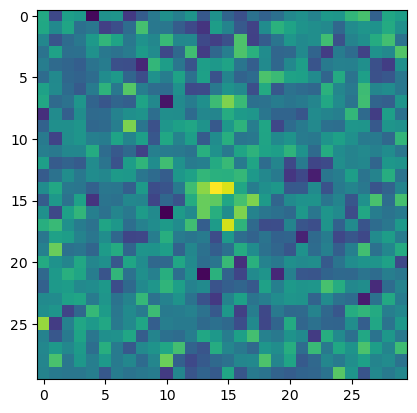

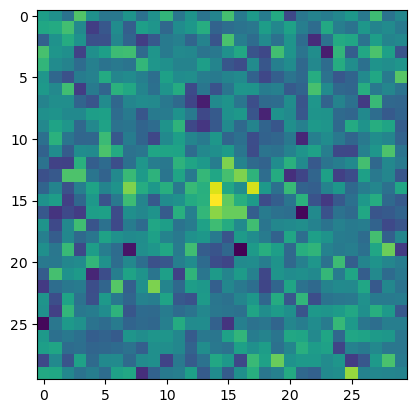

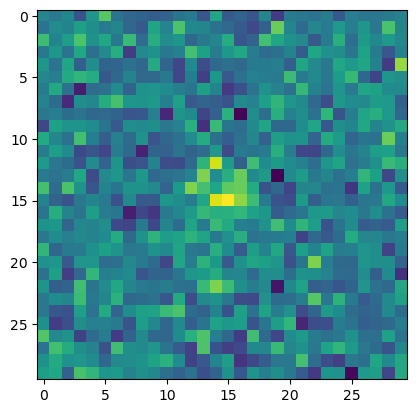

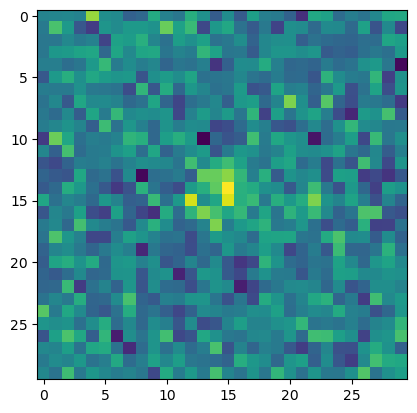

In [30]:
plt.imshow(img[565])
plt.show()
plt.imshow(img[2261])
plt.show()
plt.imshow(img[2262])
plt.show()
plt.imshow(img[2263])
plt.show()

In [55]:
def plot_from_source(visit, max_cutouts = 1000): 
    '''
    Plot for a single visit the amount of cutout
    
    Parameters:
        visit_id (int) : visit id as refered in the dia source
        max_cutouts (int) :  set a limit of cutout to plot (stop the loop after this amount)
        
    '''
    
    # Create interval object
    interval = MinMaxInterval()
    cutout_visit = call_visit(visit)[0]
    feature_visit = call_visit(visit)[1]
    
    # Display the images
    i = 0

    num_cutout = len(cutout_visit)
        
    if num_cutout > max_cutouts: 
        num_cutout = max_cutouts
    cols = 4  # nbr columns wanted
    rows = num_cutout // cols + (num_cutout % cols > 0)

    fig, axs = plt.subplots(rows, cols, figsize=(1.8 * cols, 2.4 * rows))
    axs = axs.flatten()  # Flatten the array of axes for easy iteration

    iddet = 0

    for detect in range(num_cutout):

        # Image processing steps
        vmin, vmax = interval.get_limits(cutout_visit[detect])
        
        if iddet != feature_visit['detector'][detect]:
            iddet = feature_visit['detector'][detect]
            idvis = feature_visit['visit'][detect]
            print(f'visit nbr : {idvis}, detector : {iddet}')
        norm = ImageNormalize(vmin=vmin, vmax=vmax, stretch=SqrtStretch())
        axs[detect].imshow(cutout_visit[detect], origin='lower', norm=norm)
        axs[detect].axis('off')  # Hide the axis for a cleaner look
        # Add label to each subplot
        label = feature_visit['is_injection'][detect]
        if label == True :  axs[detect].set_title(f'Injection', fontsize=16) 
        else: axs[detect].set_title(f'Real', fontsize=16)
            
            
    # Hide any remaining empty subplots
    for ax in axs[num_cutout:]:
        ax.axis('off')

    plt.tight_layout()
    idvis = feature_visit['visit']
    iddet = feature_visit['detector']
    plt.show()

In [ ]:
all_visits = [1248,11690,322,1220, 1242,  346, 358,1178, 1184, 1204, 1206, 1214, 
    11694, 11696, 11698, 11704, 11710, 11724,             
    11738, 11740, 17900, 17904,
    17906, 17926, 17948, 17950, 19680, 19684, 19694, 19696, 22632, 22662,
    23694, 23704, 23706, 23718, 29336, 29350, 30482, 30490]
plot_from_source(322, 566)

In [24]:
all_visits = [1248,11690,322,1220, 1242, 346, 358,1178, 1184, 1204, 1206, 1214, 11694, 11696, 11698, 11704, 11710, 11724, 11738, 11740, 17900, 17904, 17906, 17926, 17948, 17950, 19680, 19684, 19694, 19696, 22632, 22662, 23694, 23704, 23706, 23718, 29336, 29350, 30482, 30490]

count= 0
for visit in all_visits: 
    cutout_visit = call_visit(visit)[0]
    feature = call_visit(1248)[0]

    for cutout in cutout_visit: 
        if np.isnan(cutout).any():
            print(visit)
            count = count +1
            plt.imshow(cutout)
            plt.show()
print(count)

0


In [ ]:


ccd__ = 42

dia_srcs=butler.get("goodSeeingDiff_diaSrcTable", dataId = {'visit': 90752})
    
dataIdDict={'visit': visit__, 'ccd': ccd__}

cutout_real,nan_pos=plot_cutout(list(dia_srcs['coord_ra']),
                                list(dia_srcs['coord_dec']),
                                dataIdDict,
                                butler,
                                return_cutout=1,
                                plot_ccd=False,
                                plot_cutout=False,
                                remove_nan=True)


In [ ]:
def get_calibrated_values(fluxname, source_row, photcal):
    """
    Obtain the calibration using the DM tools for that particular image
    
    This way of converting fluxes to magnitudes is aware of the zero points
    of the image as well as the correct calculation.
    
    We can obtain then, magnitudes and fluxes in NJy
    """
    flux, err = source_row[fluxname], source_row[fluxname+'Err'] 
    cal_mag = photcal.instFluxToMagnitude(flux, err)
    cal_flux = photcal.instFluxToNanojansky(flux, err)
    #print(f"original {flux}, calibrated {cal_flux.value}")
    return cal_mag, cal_flux

In [ ]:
visit__ = All_visits 
photcal = butler.get('deepDiff_differenceExp_photoCalib',dataId={'visit': visit__, 'ccd': 42})


In [ ]:
for visit__ in All_visits:
    All_cutouts_real=[]
    All_cutouts_fake=[]
    forced_cutouts_fake=[]
    cat_real_good_all=[]
    cat_fake_input_all=[]
    cat_fake_good_all=[]
    
    for ccd__ in range(105):
        idx_ccd=df["%d"%visit__]==ccd__
        print(f"For ccd {ccd__}:\nwe have {idx_ccd.sum()} injected fakes")
        if idx_ccd.sum()==0:
            print('skiping that ccd\n')
            continue
        dataIdDict={'visit': visit__, 'ccd': ccd__}

        try:
            cutout_fake,nan_pos=plot_cutout(list(cat_fake[idx_ccd]["raJ2000"]),
                             list(cat_fake[idx_ccd]["decJ2000"]),
                             dataIdDict,butler_fake,return_cutout=1,
                             plot_ccd=False,plot_cutout=False,remove_nan=True)
            cat_fake_input_good=cat_fake[idx_ccd][["raJ2000","decJ2000","r2magVar"]][~np.in1d(np.arange(len(list(cat_fake[idx_ccd]["raJ2000"]))),nan_pos)]
            cat_fake_input_all.append(cat_fake_input_good)
            if np.array(cutout_fake).shape[0]!=0:
                forced_cutouts_fake.append(np.array(cutout_fake))
            print(f"only keeping nan-less cutouts, we have {len(cutout_fake)} fakes")
        except:
            print('fake cutout retrieval failed skiping that ccd\n')
            continue

        try:
            dia_srcs_fake=butler_fake.get("deepDiff_diaSrc",dataId={'visit': visit__, 'ccd': ccd__})

            #Src_data = SkyCoord(dia_srcs["coord_ra"]*u.radian, dia_srcs["coord_dec"]*u.radian)
            Src_fake = SkyCoord(dia_srcs_fake["coord_ra"]*u.radian, dia_srcs_fake["coord_dec"]*u.radian)
            idx_fake_S, d2d_fake_S, d3d_fake_S = Src_fake.match_to_catalog_sky(fake_cat)

            cutout_fake,nan_pos=plot_cutout(list(dia_srcs_fake['coord_ra'][d2d_fake_S.arcsec<0.2]),list(dia_srcs_fake['coord_dec'][d2d_fake_S.arcsec<0.2]),
                                dataIdDict,butler_fake,return_cutout=1,plot_ccd=False,
                                plot_cutout=False,remove_nan=True)
            idx_good=~np.in1d(np.arange(len(dia_srcs_fake['coord_ra'][d2d_fake_S.arcsec<0.2])),nan_pos)
            cat_fake_good=dia_srcs_fake.asAstropy().to_pandas()[d2d_fake_S.arcsec<0.2][idx_good]
            #mag_list=cat_fake[idx_ccd]["r2magVar"][~np.in1d(np.arange(len(list(cat_fake_R[idx_ccd]["raJ2000"]))),nan_pos)]
            #mag_fake.append(cat_fake["r2magVar"].values[idx_fake_S[d2d_fake_S.arcsec<0.2]])
            if np.array(cutout_fake).shape[0]!=0:
                cat_fake_good_all.append(cat_fake_good)
                All_cutouts_fake.append(np.array(cutout_fake))

        except:
            print('fake cutout retrieval failed skiping that ccd\n')
            continue
        print(f"Using detected src and matching we have {len(cutout_fake)} fakes")





        dia_srcs=butler_real.get("deepDiff_diaSrc",dataId={'visit': visit__, 'ccd': ccd__})
        print(f"we have {len(dia_srcs)} real sources")
        try:
            cutout_real,nan_pos=plot_cutout(list(dia_srcs['coord_ra']),list(dia_srcs['coord_dec']),
                                dataIdDict,butler_real,return_cutout=1,plot_ccd=False,
                                plot_cutout=False,remove_nan=True)
            print(np.array(cutout_real).shape)
            idx_good=~np.in1d(np.arange(len(dia_srcs['coord_ra'])),nan_pos)
            cat_real_good=dia_srcs.asAstropy().to_pandas()[idx_good]
            if np.array(cutout_real).shape[0]!=0:
                cat_real_good_all.append(cat_real_good)
                All_cutouts_real.append(np.array(cutout_real))
        except:
            print('real cutout retrieval failed skiping that ccd\n')
            continue
        print(f"only keeping nan-less cutouts, we have {len(cutout_real)} reals")

    cat_real_good_all_stack= pd.concat(cat_real_good_all)
    cat_fake_good_all_stack=pd.concat(cat_fake_good_all)
    cat_fake_input_all_stack=pd.concat(cat_fake_input_all)

    All_cutouts_real_stack=np.concatenate(All_cutouts_real,axis=0)
    All_cutouts_fake_stack=np.concatenate(All_cutouts_fake,axis=0)
    forced_cutouts_fake_stack=np.concatenate(forced_cutouts_fake,axis=0)
    
    cat_real_good_all_stack.to_csv(f'cutouts/Cat_real_sources_visit_{visit__}.csv',index=False)
    cat_fake_good_all_stack.to_csv(f'cutouts/Cat_fake_sources_visit_{visit__}.csv',index=False)
    cat_fake_input_all_stack.to_csv(f'cutouts/Cat_fake_input_sources_visit_{visit__}.csv',index=False)

    np.save(f'cutouts/Detected_fake_sources_visit_{visit__}.npy',All_cutouts_fake_stack)
    np.save(f'cutouts/Detected_real_sources_visit_{visit__}.npy',All_cutouts_real_stack)
    np.save(f'cutouts/All_fake_sources_visit_{visit__}.npy',forced_cutouts_fake_stack)

    print(f"At the end, we get:\n                    {np.shape(All_cutouts_real_stack)[0]} real sources\n                    {np.shape(All_cutouts_fake_stack)[0]} detected fake sources\n                    {np.shape(forced_cutouts_fake_stack)[0]} fake sources")

# UDEEP catalog (no fakes)

In [23]:
import pickle
with open("saved/full_dia_source_table_UDEEP.pkl", "rb") as pickle_file:
    full_dia_source_table_UDEEP = pickle.load(pickle_file)

In [ ]:
30504, 53722

In [4]:
from astropy.time import Time

# Define your date in YYYY-MM-DD format
date = "2016-01-01"

# Convert to MJD
t = Time(date, format="iso", scale="utc")
mjd = t.mjd

print(f"The MJD for {date} is: {mjd}")


The MJD for 2016-01-01 is: 57388.0


In [10]:
len(full_dia_source_table_UDEEP)

1163524

In [24]:
full_dia_source_table_UDEEP = full_dia_source_table_UDEEP[full_dia_source_table_UDEEP['visit']>=53722]

In [25]:
full_dia_source_table_UDEEP

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,is_injection
diaSourceId,,,,,,,,,,,,,,,,,,,,,
25732141207781540,59912,62,r,3496046754095189576,0,0,57456,18,2024-10-29 16:44:23.348522,150,...,False,False,False,False,False,False,False,150,2,0
25732141207781545,59912,62,r,3496046754095189577,0,0,57456,22,2024-10-29 16:44:23.348522,150,...,False,False,False,False,False,False,False,150,2,0
25732141207781546,59912,62,r,3496046754095172828,0,0,57456,28,2024-10-29 16:44:23.348522,150,...,False,False,False,False,False,False,False,150,2,0
25732141207781548,59912,62,r,3496046754095189578,0,0,57456,18,2024-10-29 16:44:23.348522,150,...,False,False,False,False,False,False,False,150,2,0
25732141207781551,59912,62,r,3496046754095189579,0,0,57456,20,2024-10-29 16:44:23.348522,150,...,False,False,False,False,False,False,False,150,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47827160227905681,111356,57,r,3495936802932396908,0,0,57866,57,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0
47827160227905683,111356,57,r,3495936802932430253,0,0,57866,29,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0
47827160227905684,111356,57,r,3495936802932393876,0,0,57866,28,2024-10-30 05:17:14.661457,150,...,False,False,False,False,False,False,False,150,2,0


In [2]:
full_dia_source_table_UDEEP[full_dia_source_table_UDEEP.index==45673747377553573]

,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,ra,...,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,coord_ra,coord_dec,is_injection
diaSourceId,,,,,,,,,,,,,,,,,,,,,
45673747377553573,106342,96,i,3496130316978896959,0,0,57835.259748,22,2024-10-11 11:07:42.509709,150.523177,...,False,False,False,False,False,False,False,150.523177,2.966187,0


In [9]:

def extract_all_single_visit(visit_id, collection):
    '''
    Query all the datasets of a single visit, 
    
    Parameters:
        visit_id (int) : visit id as refered in the dia source

    Returns:
        dataIds (list) : list of goodSeeingDiff_differenceExp.dataId
    '''
    dataIds = []
    butler = Butler(repo,collections=collection)
    registry = butler.registry
    
    result = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp', 
                                    collections=collection, 
                                    where= f"visit = {visit_id}")
    

    for ref in result:
        dataIds.append(ref.dataId)
        
    return dataIds

In [9]:
to_compute = [59912]
def save_cutout_UDEEP(collection, coadd_science=False, return_file=False, save_file=False, rotate_data=False): 
    '''
    From a given collection, perform cutout and save them visit by visit.
    
    Parameters:
        collection (str): Path to collection
    
    Returns: 
        Saves cutouts and associated feature data using pickle.
    '''
    all_cutout_in_collection = []
    all_cutout_coadd_in_collection = []
    all_cutout_science_in_collection = []
    all_features_in_collection = []
    
    butler = Butler(repo, collections=collection)
    registry = butler.registry

    # Filter the dataset
    datasetRefs = registry.queryDatasets(datasetType='goodSeeingDiff_differenceExp', collections=collection)

    # Make sure we are listing all the unique visits
    visits = []
    for ref in datasetRefs:
        visits.append(ref.dataId['visit'])
    visits = np.unique(visits)
    nbr_cutout = 0
    nbr_visit = 0
    nbr_exposure = 0
    rotation_angles = [90, 180, 270]

    # Loop through visits and process each one
    for visit in visits: 
        if visit in to_compute:
            print(visit)
            nbr_visit += 1
            all_cutout_in_visit = []
            all_cutout_coadd_in_visit = []
            all_cutout_science_in_visit = []
            all_features_in_visit = []
            new_rows = []  
            rotated_cutouts = []
            for ref in extract_all_single_visit(visit, collection): 
                nbr_exposure += 1

                # Extract the image from the butler exposure
                diff_array = butler.get('goodSeeingDiff_differenceExp', dataId=ref).getImage().array  
                if coadd_science: 
                    coadd_array = butler.get('goodSeeingDiff_templateExp', dataId=ref).getImage().array  
                    science_array = butler.get('calexp', dataId=ref).getImage().array  

                full_dia_source_table = butler.get('goodSeeingDiff_diaSrcTable', dataId=ref)  # Object coordinates
                full_dia_source_table['is_injection'] = 0
                coord = full_dia_source_table
                num_detections = len(coord['x'])
                coord['rotation_angle'] = None

                for detect in range(num_detections):
                    cutout = Cutout2D(diff_array, (coord['x'][detect], coord['y'][detect]), 30)  
                    if coadd_science: 
                        cutout_coadd = Cutout2D(coadd_array, (coord['x'][detect]+20, coord['y'][detect]+20), 30)  
                        cutout_science = Cutout2D(science_array, (coord['x'][detect], coord['y'][detect]), 30)  

                    # Check the cutout format and save if valid
                    if cutout.data.shape == (30, 30) and not np.isnan(cutout.data).any():
                        if rotate_data:
                            original_cutout = cutout.data
                            new_row = coord.iloc[[detect]].copy() 
                            for angle in rotation_angles:  
                                rotated_cutout = rotate(cutout.data, angle, reshape=False)  
                                rotated_row = new_row.copy()  
                                rotated_row['rotation_angle'] = angle  
                                new_rows.append(rotated_row)  
                                rotated_cutouts.append(rotated_cutout)
                                nbr_cutout += 1

                        all_cutout_in_visit.append(cutout.data)                 
                        all_features_in_visit.append(coord.iloc[detect])
                        nbr_cutout += 1

                        if coadd_science:
                            all_cutout_coadd_in_visit.append(cutout_coadd.data)
                            all_cutout_science_in_visit.append(cutout_science.data)

            all_features_in_visit = pd.DataFrame(all_features_in_visit)
            if rotate_data:
                new_rows_df = pd.concat(new_rows, ignore_index=True)
                all_cutout_in_visit = np.concatenate((all_cutout_in_visit, rotated_cutouts))
                all_features_in_visit = pd.concat([all_features_in_visit, new_rows_df], ignore_index=True)

            if save_file:
                if rotate_data:
                    with open(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Detected_obj_sources_rotated_visit_{visit}_UDEEP.pkl', 'wb') as f:
                        pickle.dump(all_cutout_in_visit, f)
                    all_features_in_visit.to_pickle(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Detected_obj_sources_rotated_visit_{visit}_UDEEP_df.pkl')
                    if coadd_science:
                        with open(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Coadd_detected_obj_sources_visit_{visit}_UDEEP.pkl', 'wb') as f:
                            pickle.dump(all_cutout_coadd_in_visit, f)
                        with open(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Science_detected_obj_sources_visit_{visit}_UDEEP.pkl', 'wb') as f:
                            pickle.dump(all_cutout_science_in_visit, f)
                else:
                    with open(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Detected_obj_sources_visit_{visit}_UDEEP.pkl', 'wb') as f:
                        pickle.dump(all_cutout_in_visit, f)
                    all_features_in_visit.to_pickle(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Detected_obj_sources_visit_{visit}_UDEEP_df.pkl')
                    if coadd_science:
                        with open(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Coadd_detected_obj_sources_visit_{visit}_UDEEP.pkl', 'wb') as f:
                            pickle.dump(all_cutout_coadd_in_visit, f)
                        with open(f'/sps/lsst/groups/transients/HSC/fouchez/raphael/Science_detected_obj_sources_visit_{visit}_UDEEP.pkl', 'wb') as f:
                            pickle.dump(all_cutout_science_in_visit, f)
            if return_file:
                all_cutout_coadd_in_collection.append(all_cutout_coadd_in_visit)
                all_cutout_science_in_collection.append(all_cutout_science_in_visit)
                all_cutout_in_collection.append(all_cutout_in_visit)
                all_features_in_collection.append(all_features_in_visit)
            
        
    print(f'Visits analyzed: {nbr_visit}, Exposures explored: {nbr_exposure}, Cutouts made: {nbr_cutout}')

    if return_file:
        return all_cutout_in_collection, all_cutout_coadd_in_collection, all_cutout_science_in_collection, all_features_in_collection



In [10]:
diff, coadd, calexp, features = save_cutout_UDEEP(collection, coadd_science= True, return_file = True, save_file = False, rotate_data = False)
features = features[0].reset_index(drop=True)


59912


UserExpressionError: Error in query expression "visit = 59912": No value(s) for governor dimensions {'instrument'} in expression that references dependent dimensions. 'Governor' dimensions must always be specified completely in either the query expression (via simple 'name=<value>' terms, not 'IN' terms) or in a data ID passed to the query method.

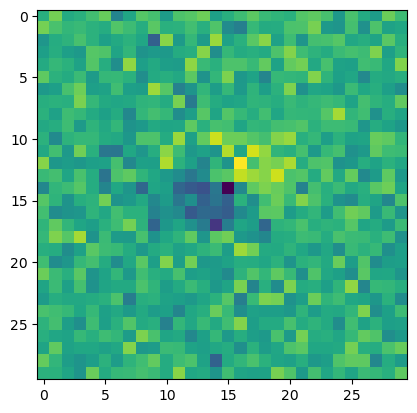

In [135]:
plt.imshow(diff[0][4])

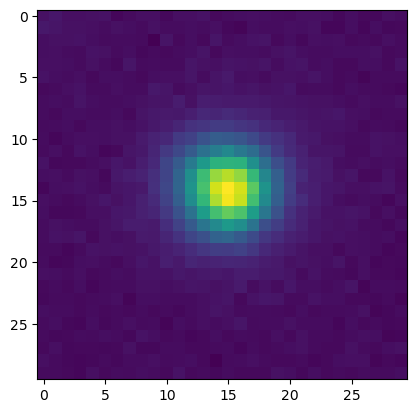

In [136]:
plt.imshow(calexp[0][4])

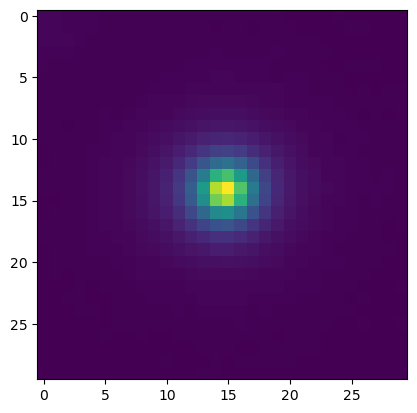

In [137]:
plt.imshow(coadd[0][4])


In [106]:
features[features.index==317]

,diaSourceId,visit,detector,band,diaObjectId,ssObjectId,parentDiaSourceId,midpointMjdTai,bboxSize,time_processed,...,shape_flag_parent_source,trail_flag_edge,pixelFlags_streak,pixelFlags_streakCenter,pixelFlags_injected,pixelFlags_injectedCenter,pixelFlags_injected_template,pixelFlags_injected_templateCenter,is_injection,rotation_angle
317,138506252845074,322,97,y,0,0,0,56741,20,2024-10-11 13:03:34.747943,...,False,False,False,False,False,False,False,False,0,None


In [ ]:
print(features[0].columns)